## Запуск предсказаний Boltz

### v1 — стандартный запуск
```bash
boltz predict data/ampc_yamls
```

### v2 — ускоренный запуск
```bash
boltz predict data/ampc_yamls \
  --recycling_steps 1 \
  --sampling_steps 2 \
  --sampling_steps_affinity 2 \
  --diffusion_samples_affinity 1
```

In [1]:
import pandas as pd 

df_ki = pd.read_csv('../data/processed/ampc/ampc_summary.tsv', sep='\t')
df_ki["target"] = pd.to_numeric(df_ki["Ki (uM)"], errors="coerce").notna().astype(int)
print(f"Row number: {df_ki.shape[0]}")
print(f"Mean of target column: {df_ki["target"].mean():.3f}")
print()

df_aff = pd.read_csv('../results/boltz_results_ampc_v1_affinity_summary.tsv', sep='\t') 
df_v1 = df_ki.merge(df_aff, on='id')

df_aff = pd.read_csv('../results/boltz_results_ampc_v2_affinity_summary.tsv', sep='\t') 
df_v2 = df_ki.merge(df_aff, on='id')

print(f"v1 row number: {df_v1.shape[0]}")
print(f"Mean of target column: {df_v1["target"].mean():.3f}")
print()

print(f"v2 row number: {df_v2.shape[0]}")
print(f"Mean of target column: {df_v2["target"].mean():.3f}")

Row number: 1521
Mean of target column: 0.196

v1 row number: 1502
Mean of target column: 0.197

v2 row number: 1502
Mean of target column: 0.197


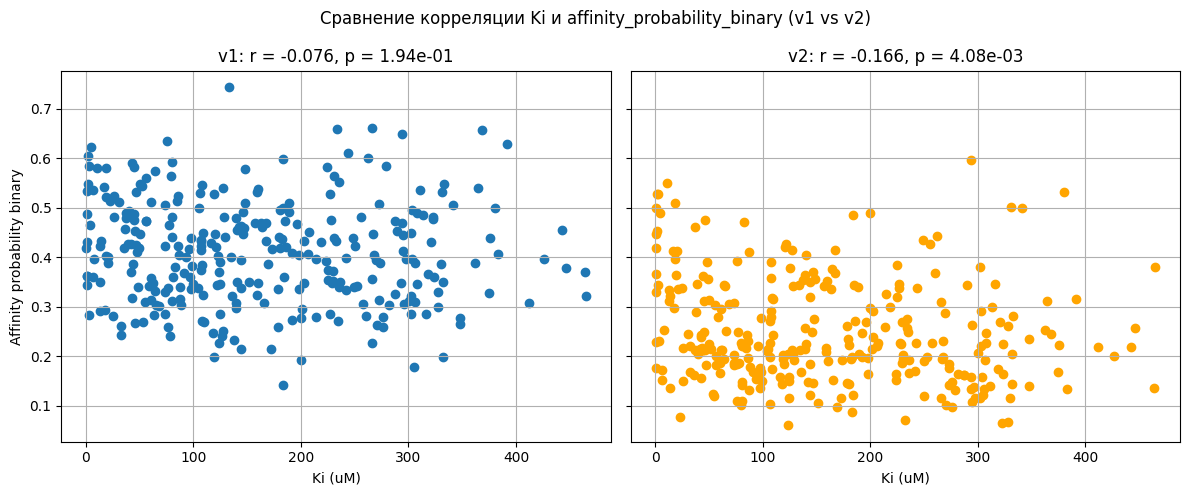

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def clean_numeric(series):
    return pd.to_numeric(series, errors="coerce")

# добавляем числовой Ki
df_v1["Ki_num"] = clean_numeric(df_v1["Ki (uM)"])
df_v2["Ki_num"] = clean_numeric(df_v2["Ki (uM)"])

# убираем NaN
df_v1_num = df_v1.dropna(subset=["Ki_num"])
df_v2_num = df_v2.dropna(subset=["Ki_num"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# v1
r1, p1 = pearsonr(df_v1_num["Ki_num"], df_v1_num["affinity_probability_binary"])
axes[0].scatter(df_v1_num["Ki_num"], df_v1_num["affinity_probability_binary"])
axes[0].set_xlabel("Ki (uM)")
axes[0].set_ylabel("Affinity probability binary")
axes[0].set_title(f"v1: r = {r1:.3f}, p = {p1:.2e}")
axes[0].grid(True)

# v2
r2, p2 = pearsonr(df_v2_num["Ki_num"], df_v2_num["affinity_probability_binary"])
axes[1].scatter(df_v2_num["Ki_num"], df_v2_num["affinity_probability_binary"], color="orange")
axes[1].set_xlabel("Ki (uM)")
axes[1].set_title(f"v2: r = {r2:.3f}, p = {p2:.2e}")
axes[1].grid(True)

plt.suptitle("Сравнение корреляции Ki и affinity_probability_binary (v1 vs v2)")
plt.tight_layout()
plt.show()


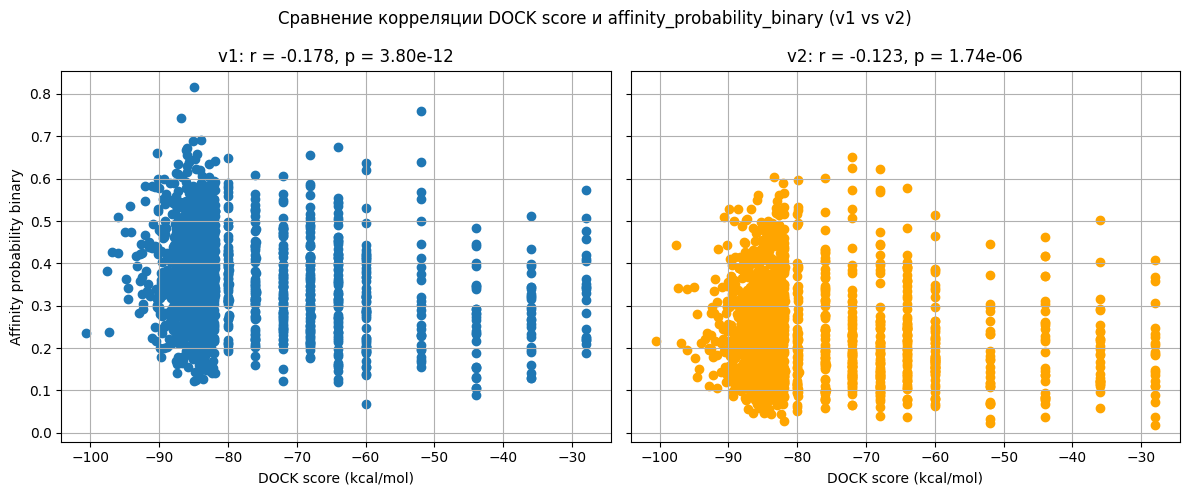

In [3]:
def plot_corr(df1, df2, col_x, col_y, label_x, label_y, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # v1
    r1, p1 = pearsonr(df1[col_x], df1[col_y])
    axes[0].scatter(df1[col_x], df1[col_y])
    axes[0].set_xlabel(label_x)
    axes[0].set_ylabel(label_y)
    axes[0].set_title(f"v1: r = {r1:.3f}, p = {p1:.2e}")
    axes[0].grid(True)

    # v2
    r2, p2 = pearsonr(df2[col_x], df2[col_y])
    axes[1].scatter(df2[col_x], df2[col_y], color="orange")
    axes[1].set_xlabel(label_x)
    axes[1].set_title(f"v2: r = {r2:.3f}, p = {p2:.2e}")
    axes[1].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# вызов для DOCK score vs affinity_probability_binary
plot_corr(
    df_v1, df_v2,
    col_x="DOCK score (kcal/mol)",
    col_y="affinity_probability_binary",
    label_x="DOCK score (kcal/mol)",
    label_y="Affinity probability binary",
    title="Сравнение корреляции DOCK score и affinity_probability_binary (v1 vs v2)"
)


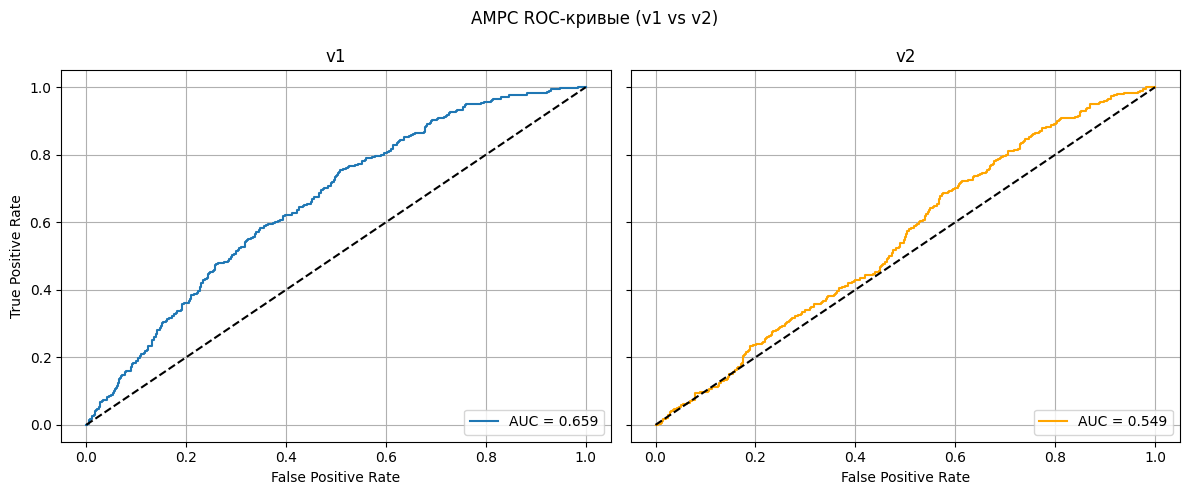

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc(df1, df2, label, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    # v1
    auc1 = roc_auc_score(df1["target"], df1[label])
    fpr1, tpr1, _ = roc_curve(df1["target"], df1[label])
    axes[0].plot(fpr1, tpr1, label=f"AUC = {auc1:.3f}")
    axes[0].plot([0, 1], [0, 1], "k--")
    axes[0].set_title("v1")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend(loc="lower right")
    axes[0].grid(True)

    # v2
    auc2 = roc_auc_score(df2["target"], df2[label])
    fpr2, tpr2, _ = roc_curve(df2["target"], df2[label])
    axes[1].plot(fpr2, tpr2, label=f"AUC = {auc2:.3f}", color="orange")
    axes[1].plot([0, 1], [0, 1], "k--")
    axes[1].set_title("v2")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].legend(loc="lower right")
    axes[1].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# вызов
plot_roc(df_v1.copy(), df_v2.copy(),
         label="affinity_probability_binary",
         title="AMPC ROC-кривые (v1 vs v2)")
